# Using BGLS to sample from Matrix Product State Circuits

Here we will explore working with matrix product states (mps) using cirq's quimb-based MPSState class.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

import cirq
import cirq.contrib.quimb as ccq
import cirq.contrib.quimb.mps_simulator

import quimb.tensor as qtn

import bgls

In [2]:
def cirq_mps_bitstring_probability(
    mps: cirq.contrib.quimb.MPSState, bitstring: str
) -> float:
    """
    Returns the probability of measuring the `bitstring` (|z⟩) in the
    'cirq.contrib.quimb.MPSState' mps.
    Args:
        mps: Matrix Product State as a 'cirq.contrib.quimb.MPSState'.
        bitstring: Bitstring |z⟩ as a binary string.
    """
    M_subset = []
    for i, Ai in enumerate(mps.M):
        qubit_index = mps.i_str(i)
        # selecting the component with matching bitstring:
        A_subset = Ai.isel({qubit_index: int(bitstring[i])})
        M_subset.append(A_subset)

    tensor_network = qtn.TensorNetwork(M_subset)
    state_vector = tensor_network.contract(inplace=False)
    return np.power(np.abs(state_vector), 2)


To begin, we note that the state of n qubits can be represented as a matrix product state as per: $|\Psi> = \sum_{\{s\}}Tr[A_1^{s_1}...A_n^{s_n}]|s_1...s_n>$, where $s_i=0,1$. In particular, each $A_i^{s_i}$ is of order $\chi$ that scales with the entanglement of the system. Retrieving information about the state e.g. bitstring amplitudes involves contraction of these tensors, hence this representation is most advantageous in cases of low/local entanglement.

We can create a cirq circuit and visualize it as a tensor network as follows. We take the example at https://quimb.readthedocs.io/en/latest/tensor-circuit.html#simulation-steps and use a large GHZ circuit with randomly sequenced CNOTs:

In [3]:
size = 8
qs = cirq.LineQubit.range(size)
circuit = cirq.Circuit(cirq.H.on(qs[0]))
sequence = np.arange(size-1)
np.random.shuffle(sequence)
for i in sequence:
    circuit.append(cirq.CNOT.on(qs[0], qs[i+1]))

circuit

0: ───H───@───@───@───@───@───@───@───
          │   │   │   │   │   │   │
1: ───────┼───┼───┼───┼───X───┼───┼───
          │   │   │   │       │   │
2: ───────┼───┼───X───┼───────┼───┼───
          │   │       │       │   │
3: ───────X───┼───────┼───────┼───┼───
              │       │       │   │
4: ───────────┼───────┼───────X───┼───
              │       │           │
5: ───────────┼───────X───────────┼───
              │                   │
6: ───────────┼───────────────────X───
              │
7: ───────────X───────────────────────

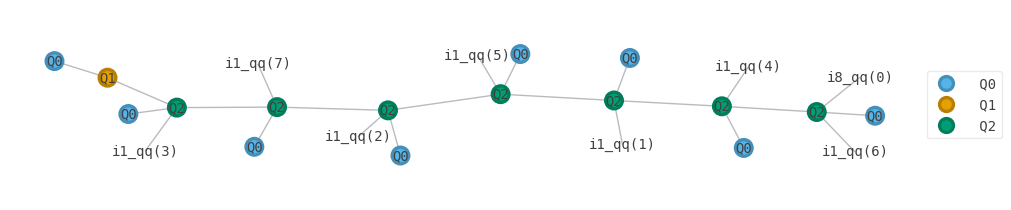

In [4]:
# convert to tensor network:
tensors, qubit_frontier, fix = ccq.circuit_to_tensors(circuit, qs, initial_state=0)
tn = qtn.TensorNetwork(tensors)
color = [f'Q{i}' for i in [0, 1, 2]]
tn.draw(color=color, figsize=(10,10), fix=fix)

Following the discussion at https://github.com/quantumlib/Cirq/blob/master/cirq-core/cirq/contrib/quimb/Cirq-to-Tensor-Networks.ipynb we can read this representation of the state vector as follows: Qi represent i-qubit operations, and Q0 represent the qubits, in their initial $|0>$ state. Open legs represent components of the state vector, and for $ij\_ qq(l)$ represent the lth component. Thus we see the number of Q0 match the number of qubits present, and can read the network from left to right. We first apply the 1-qubit Hadamard in orange to the first qubit, and then sequentially apply each 2-qubit CNOT between it and the remaining qubits. Once we have incorporated each qubit it is no longer used, and its component of the state vector becomes available. Finally after entangling with all qubits, the first qubit's state vector component emerges as well.

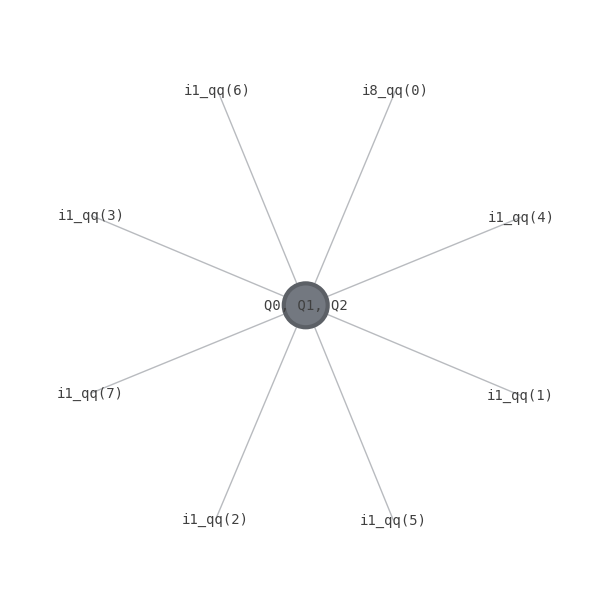

In [5]:
tn2 = tn.contract()
tn2.draw(fix=fix)

We see above that contracting this circuit makes available all components of the state vector, and is the equivalent of fully simulating the circuit.

Now we begin working with cirq's MPSState class which integrates this into native cirq circuits. We can recreate this by initializing such a state, and using cirq.act_on for each subsequent gate as follows. Here the backend uses a simplified representation for display, with $i_j$ representing the jth qubit state vector component, and nodes representing gates. Again we first act on $i_0$ and then subsequentely between it and each other qubit. 

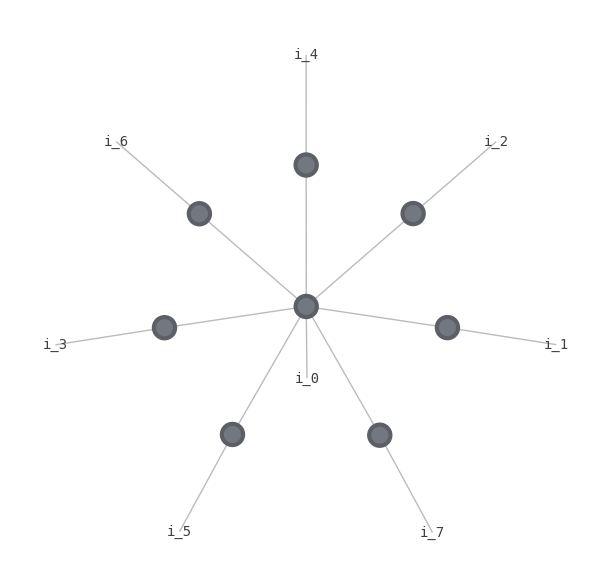

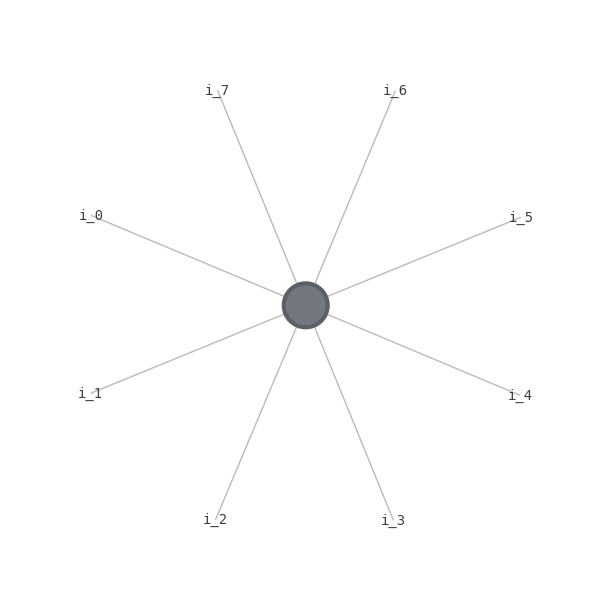

In [6]:
mps_state = cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    )
for op in circuit.all_operations():
    cirq.act_on(op, mps_state)

mps_tn = qtn.TensorNetwork(mps_state.M)
mps_tn.draw()
contracted = mps_tn.contract()
contracted.draw()

The primary thing we need to determine from such a MPSState to use in BGLS is the amplitudes at a given step for various bitstrings. We can examine the list of tensors in the MPS representation through its property $M$. We make the following observations. The number of tensors is equal to the number of qubits in the circuit. Each tensor's first dimension is 2; this represents the 2 basis components of qubits, i.e. $|0>, |1>$. Then for each qubit, every time it is entangled with another gate via a 2-qubit gate, it gains another size 2 dimension. Hence each peripheral qubit is entangled once and has a single additional axis, whereas the first qubit has an extra axis for each qubit it was entangled with.

In [7]:
mps_state.M

[Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2), inds=('mu_0_3', 'mu_0_1', 'mu_0_5', 'mu_0_2', 'mu_0_7', 'mu_0_4', 'i_0', 'mu_0_6'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_1', 'i_1'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_2', 'i_2'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_3', 'i_3'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_4', 'i_4'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_5', 'i_5'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_6', 'i_6'), tags=oset([])),
 Tensor(shape=(2, 2), inds=('mu_0_7', 'i_7'), tags=oset([]))]

A naive technique to compute bitstring amplitudes would be to fully contract the tensor network as per the ```MPSState.state_vector()``` function. However, a major insight is that, by specifying the bitstring, at each qubit we can eliminate the first axis, depending on whether that qubit's corresponding bitstring is 0 or 1, leading to an exponential speedup of the requisite tensor contraction. This makes up the core of our ```cirq_mps_bitstring_probability()``` function, as we can see below.

In [8]:
# e.g. bitstring "11111111" for the above
bitstring = "11111111"
M_subset = []
for i, Ai in enumerate(mps_state.M):
    qubit_index = mps_state.i_str(i)
    # selecting the component with matching bitstring:
    A_subset = Ai.isel({qubit_index: int(bitstring[i])})
    M_subset.append(A_subset)
M_subset

[Tensor(shape=(2, 2, 2, 2, 2, 2, 2), inds=('mu_0_3', 'mu_0_1', 'mu_0_5', 'mu_0_2', 'mu_0_7', 'mu_0_4', 'mu_0_6'), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_1',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_2',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_3',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_4',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_5',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_6',), tags=oset([])),
 Tensor(shape=(2,), inds=('mu_0_7',), tags=oset([]))]

To get the amplitude we then follow the ```state_vector()``` functionality, and turn this list into a tensor network and contract. Because of the above, this now yields a scalar rather than a full tensor. For the $0...0$ and $1...1$ bitstrings we expect probability $1/2$.

In [9]:
M_tn = qtn.TensorNetwork(M_subset)
M_amp = M_tn.contract(inplace=False)
np.power(np.abs(M_amp), 2)

0.4999999999999998

## Running on BGLS

Sampling now looks the same as with any other representation, and we can see the proper probability distributions:

In [10]:
mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
)
result = mps_sim.run(circuit+cirq.measure(qs, key="m"), repetitions=500)


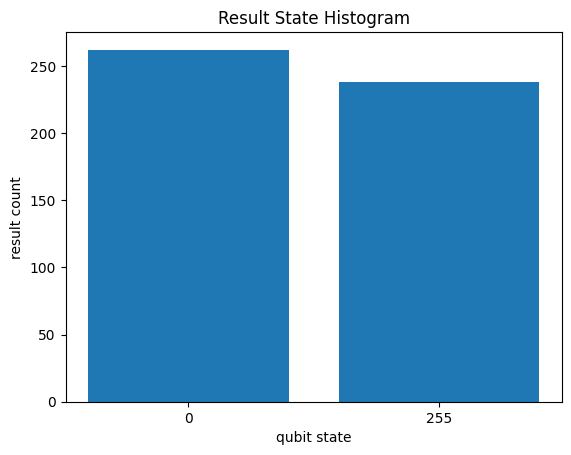

In [11]:
hist = result.histogram(key='m')
_ = cirq.plot_state_histogram(hist, plt.subplot())
plt.show()

Let's now look how this scales as opposed to the standard state-vector sampler, first for this GHZ example.

In [12]:
widths = [2, 3, 4, 8, 10, 14, 20, 22]
statevec_times = []
mps_times = []

for size in widths:
    qs = cirq.LineQubit.range(size)
    circuit = cirq.Circuit(cirq.H.on(qs[0]))
    sequence = np.arange(size-1)
    np.random.shuffle(sequence)
    for i in sequence:
        circuit.append(cirq.CNOT.on(qs[0], qs[i+1]))
    circuit.append(cirq.measure(qs, key="m"))

    vec_sim = bgls.Simulator(
    cirq.StateVectorSimulationState(
            qubits=qs, initial_state=0
        ),
    cirq.act_on,
    bgls.utils.cirq_state_vector_bitstring_probability
    )
    
    mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    )

    start = time.time()
    result = vec_sim.run(circuit, repetitions=1)
    end = time.time()
    statevec_times.append(end-start)
    start = time.time()
    result = mps_sim.run(circuit, repetitions=1)
    end = time.time()
    mps_times.append(end-start)


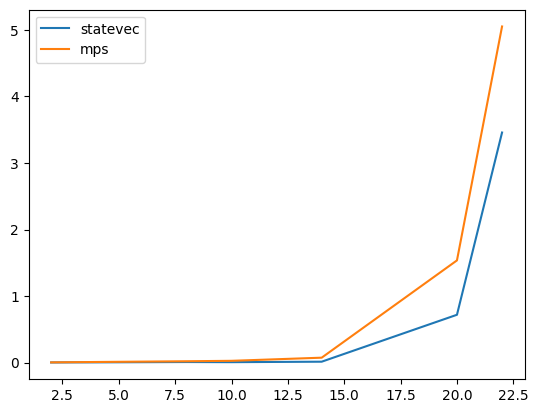

In [13]:
plt.plot(widths, statevec_times, label="statevec")
plt.plot(widths, mps_times, label="mps")
plt.legend()
plt.show()

We see that both the state vector and mps samplers scale exponentially in the number of qubits in the system for the case of the n-qubit ghz circuit.

Now for a random circuit instead

In [14]:
widths = [2, 3, 4, 8, 10, 12, 14, 18, 20, 22]
statevec_times = []
mps_times = []

for size in widths:
    qs = cirq.LineQubit.range(size)
    circuit = cirq.testing.random_circuit(qs, n_moments=10, op_density=0.4)
    circuit.append(cirq.measure(qs, key="m"))

    vec_sim = bgls.Simulator(
    cirq.StateVectorSimulationState(
            qubits=qs, initial_state=0
        ),
    cirq.act_on,
    bgls.utils.cirq_state_vector_bitstring_probability
    )
    
    mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    )


    start = time.time()
    result = vec_sim.run(circuit, repetitions=1)
    end = time.time()
    statevec_times.append(end-start)
    start = time.time()
    result = mps_sim.run(circuit, repetitions=1)
    end = time.time()
    mps_times.append(end-start)

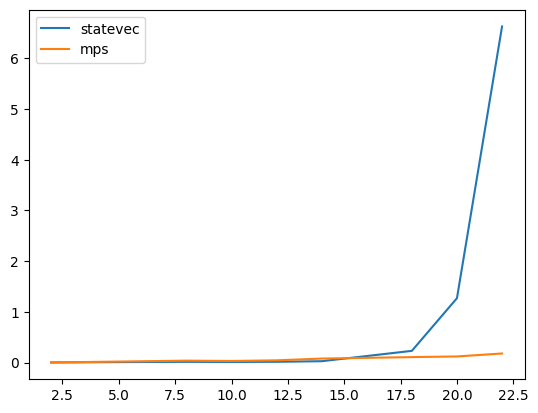

In [15]:
plt.plot(widths, statevec_times, label="statevec")
plt.plot(widths, mps_times, label="mps")
plt.legend()
plt.show()

We notice again the exponential runtime scaling in the state vector sampler, but now see much better scaling in the mps sampler.

We see that we actually have quite poor performance for the GHZ circuit, yet farily good performance for random ones. This is explained as follows. Whereas one can describe the final ghz state very simply with a MPS, our sampling algorithm updates at each step when the state is not yet ghz, and cannot use the global simplification. In general MPS scale exponentially in the connectivity of the circuit, and a ghz state is actually *maximally* entangled, meaning we would expect the exponential runtime we observe. Instead we can seek performance improvements in large yet lowly-entangled circuits.

As an example, we can examine how runtime scales as an increasing subset of a large circuit is entangled into a ghz state:

In [16]:
size = 30
numcnots = [1, 2, 4, 8, 14, 18, 20]
mps_times = []

for numcnot in numcnots:
    qs = cirq.LineQubit.range(size)
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on(qs[0]))
    for i in range(size):
        if i < numcnot:
            circuit.append(cirq.CNOT.on(qs[0], qs[i+1]))
        else:
            circuit.append(cirq.X.on(qs[i]))
    
    circuit.append(cirq.measure(qs, key="m"))

    mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    )

    start = time.time()
    result = mps_sim.run(circuit, repetitions=1)
    end = time.time()
    mps_times.append(end-start)

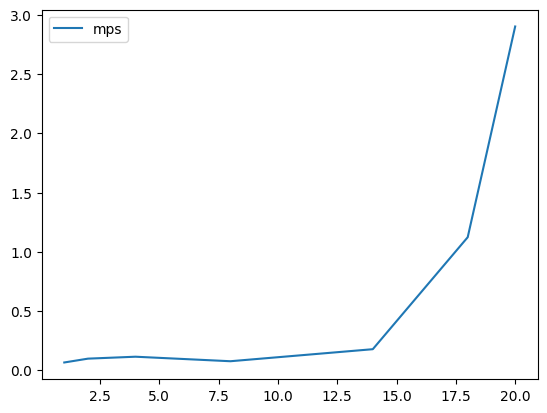

In [17]:
plt.plot(numcnots, mps_times, label="mps")
plt.legend()
plt.show()

To drive this home, we can take a fixed number of entangled qubits and increase the number of unentangled. We expect essentially constant runtime for the mps, despite the state vector simulator continuing to scale exponentially.

In [18]:
numcnots = 5
fullsizes = [6, 8, 10, 12, 14, 16, 18, 20]
mps_times = []
statevec_times = []

for fullsize in fullsizes:
    qs = cirq.LineQubit.range(fullsize)
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on(qs[0]))
    for i in range(fullsize):
        if i < numcnots:
            circuit.append(cirq.CNOT.on(qs[0], qs[i+1]))
        else:
            circuit.append(cirq.X.on(qs[i]))
    circuit.append(cirq.measure(qs, key="m"))

    vec_sim = bgls.Simulator(
    cirq.StateVectorSimulationState(
            qubits=qs, initial_state=0
        ),
    cirq.act_on,
    bgls.utils.cirq_state_vector_bitstring_probability
    )

    mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    )

    start = time.time()
    result = mps_sim.run(circuit, repetitions=1)
    end = time.time()
    mps_times.append(end-start)
    start = time.time()
    result = vec_sim.run(circuit, repetitions=1)
    end = time.time()
    statevec_times.append(end-start)

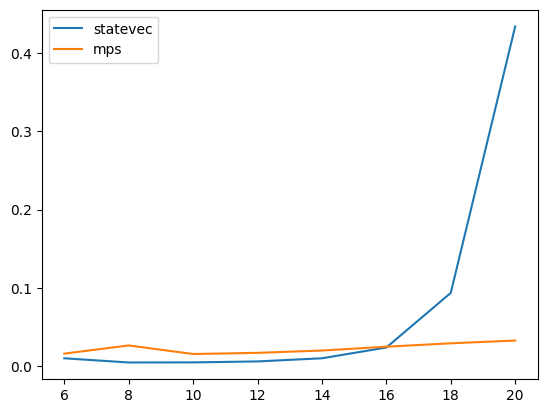

In [19]:
plt.plot(fullsizes, statevec_times, label="statevec")
plt.plot(fullsizes, mps_times, label="mps")
plt.legend()
plt.show()

Conversely for a fixed amount of entanglement (i.e. 2-qubit gates), we see a modest linear scaling in runtime with the number of 1-qubit gates:

In [20]:
size = 30
numgates = [1, 2, 4, 8, 14, 18, 20, 24, 28, 30]
numcnot = 5
mps_times = []

for numgate in numgates:
    qs = cirq.LineQubit.range(size)
    circuit = cirq.Circuit()
    for i in range(len(qs)):
        circuit.append(cirq.H.on(qs[i]))
    # entangle just a subset at beginning
    for i in range(numcnot):
        circuit.append(cirq.CNOT.on(qs[i], qs[i+1]))
    circuit.append(cirq.testing.random_circuit(qs, n_moments=numgate, op_density=0.4, gate_domain={cirq.X:1, cirq.Y:1, cirq.H:1, cirq.S:1}))
    circuit.append(cirq.measure(qs, key="m"))


    mps_sim = bgls.Simulator(
    cirq.contrib.quimb.MPSState(
        qubits=qs, initial_state=0, prng=np.random.RandomState()
    ),
    cirq.act_on,
    cirq_mps_bitstring_probability,
    )

    start = time.time()
    result = mps_sim.run(circuit, repetitions=1)
    end = time.time()
    mps_times.append(end-start)

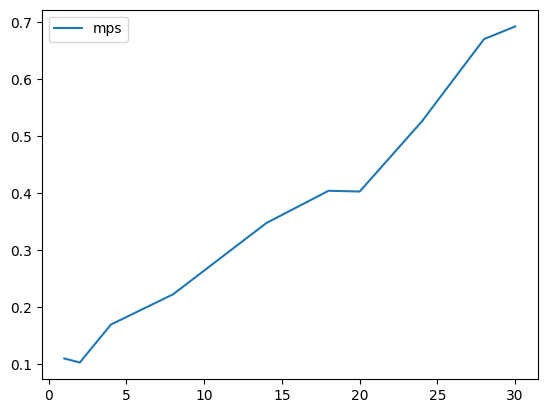

In [21]:
plt.plot(numgates, mps_times, label="mps")
plt.legend()
plt.show()